# Obligatorio - Taller de Deep Learning

**Materia:** Taller de Deep Learning  
**Postgrado:** Master/Diploma de especialización en Inteligencia Artificial  
**Estudiante(s):**
- Reichel Larez - 344474
- Octavio Revetria - 232745

En este notebook se implementa desde cero un modelo de segmentación de imágenes basado en el paper:

U-Net: Convolutional Networks for Biomedical Image Segmentation (Ronneberger et al., 2015)

El objetivo es:
- Analizar el dataset de segmentación proporcionado para el obligatorio.
- Implementar una arquitectura U-Net en PyTorch.
- Entrenar y evaluar el modelo con la métrica **Dice Coefficient**.
- Generar predicciones y codificarlas con **Run-Length Encoding (RLE)** para subirlas a Kaggle.

---

## **1. Exploración  y Análisis de los datos**

El dataset está diseñado para **segmentación binaria de personas**: cada imagen contiene una o más personas, y las máscaras indican con `1` los píxeles pertenecientes a la persona y con `0` el fondo. Las imágenes originales tienen un tamaño de **800×800 píxeles**.

La estructura de carpetas es:

- `train/images/` → imágenes de entrenamiento  
- `train/masks/` → máscaras correspondientes  
- `test/images/` → imágenes de test (sin máscara)

Durante la inspección inicial se verificó que:

- La cantidad de imágenes coincide con la de máscaras.  
- Los nombres de archivo están correctamente emparejados.  
- Las imágenes presentan shapes como `(800, 800, 3)`, `(800, 800, 4)` y ocasionalmente `(800, 800)`.  
- Las máscaras siempre tienen shape `(800, 800, 3)` y contienen valores binarios.

### Distribución de clases

El análisis de una imagen típica muestra un desbalance notable:

- **Total de píxeles:** 800 × 800 = 640.000  
- **Píxeles de persona:** ~2%  
- **Píxeles de fondo:** ~98%

Aunque proviene de un caso puntual, este patrón se repite visualmente en la mayor parte del dataset: las personas ocupan una fracción pequeña de la imagen. No es un defecto del dataset, sino una característica habitual de esta tarea.

### Implicaciones para el entrenamiento

Este desbalance influye en el aprendizaje del modelo:

- Puede aprender a predecir “todo fondo” y aun así obtener una pérdida baja.  
- La U-Net requiere señales claras para aprender bordes y formas sin sesgarse hacia la clase mayoritaria.


### Bibliotecas y funciones

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from glob import glob
from Utils import visualizar_predicciones, train, train_full, mask_to_rle, dice_coef

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


### Rutas de los datos

In [16]:
DATA_DIR = "./data" 
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train", "images")
TRAIN_MASK_DIR = os.path.join(DATA_DIR, "train", "masks")
TEST_IMG_DIR  = os.path.join(DATA_DIR, "test", "images")

### Imágenes y Máscaras de entrenamiento
Seleccionamos cinco imágenes de referencia para analizar las principales características del set de datos.

In [17]:
print(os.listdir(DATA_DIR))
print("Ejemplo imágenes:", os.listdir(TRAIN_IMG_DIR)[:5])
print("Ejemplo masks:", os.listdir(TRAIN_MASK_DIR)[:5])
print("Cantidad de imágenes de train:", len(os.listdir(TRAIN_IMG_DIR)))
print("Cantidad de máscaras de train:", len(os.listdir(TRAIN_MASK_DIR)))

['test', 'train']
Ejemplo imágenes: ['1.png', '10.png', '100.png', '1000.png', '1001.png']
Ejemplo masks: ['1.png', '10.png', '100.png', '1000.png', '1001.png']
Cantidad de imágenes de train: 2133
Cantidad de máscaras de train: 2133


Imagen shape: (800, 800, 3)


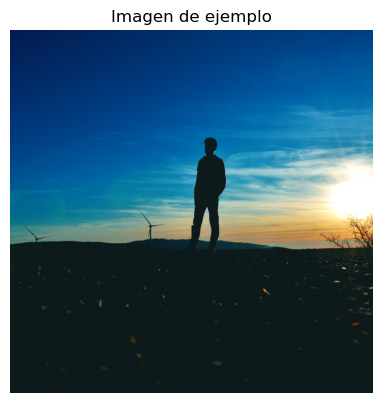

In [18]:
sample_index = 0 
img_name = os.listdir(TRAIN_IMG_DIR)[sample_index]

image_paths = sorted(glob(os.path.join(TRAIN_IMG_DIR, "*")))
mask_paths  = sorted(glob(os.path.join(TRAIN_MASK_DIR, "*")))

img = np.array(Image.open(image_paths[sample_index]))
print("Imagen shape:", img.shape)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Imagen de ejemplo"); plt.axis("off")
plt.tight_layout()
plt.show()

### Explorar el shape de todas las imágenes y máscaras del set de datos

In [19]:
shapes_img = set()
shapes_mask = set()

for name in tqdm(os.listdir(TRAIN_IMG_DIR)):
    img = np.array(Image.open(os.path.join(TRAIN_IMG_DIR, name)))
    mask = np.array(Image.open(os.path.join(TRAIN_MASK_DIR, name)))
    shapes_img.add(img.shape)
    shapes_mask.add(mask.shape)

print("Shapes de imágenes:", shapes_img)
print("Shapes de máscaras:", shapes_mask)

100%|██████████| 2133/2133 [00:42<00:00, 49.68it/s]

Shapes de imágenes: {(800, 800, 3), (800, 800, 4), (800, 800)}
Shapes de máscaras: {(800, 800, 3)}


### Distribución y carácteristicas de las máscaras



INFORMACIÓN DEL DATASET DE MÁSCARAS DE ENTRENAMIENTO

Cantidad de máscaras de entrenamiento: 2133
Shape de la máscaras: (800, 800, 3)
Tamaño máscara original: (800, 800)
Modo máscara: RGB
Valores únicos en la máscara: [0 1]
Min: 0 Max: 1

La máscara está en RGB, se tomará solo un canal para convertir a escala de grises.

Valores únicos en máscara (un canal): [0 1]


INFORMACIÓN DE PÍXELES EN LA MÁSCARA DE ENTRENAMIENTO


Total de píxeles: 640000
Píxeles de persona (valor > 0): 12762 (1.99%)
Píxeles de fondo (valor = 0): 627238 (98.01%)



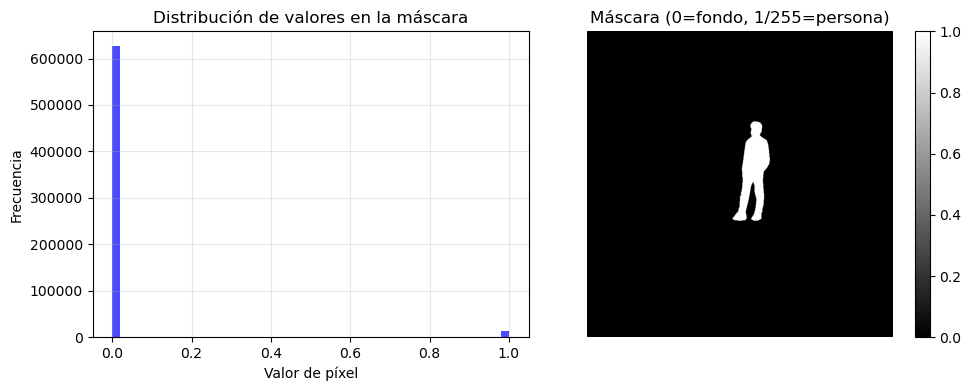

In [20]:
mask = Image.open(mask_paths[sample_index])
mask_array = np.array(mask)

assert len(image_paths) == len(mask_paths), "No coinciden las cantidades de imágenes y máscaras."


print("\n" + "="*60)
print("\nINFORMACIÓN DEL DATASET DE MÁSCARAS DE ENTRENAMIENTO")
print("\n" + "="*60)

print("Cantidad de máscaras de entrenamiento:", len(mask_paths))
print("Shape de la máscaras:", mask_array.shape)
print("Tamaño máscara original:", mask.size)
print("Modo máscara:", mask.mode)
print("Valores únicos en la máscara:", np.unique(mask_array))
print("Min:", mask_array.min(), "Max:", mask_array.max())

print("="*60 + "\n")

# Convertir a escala de grises si es necesario y verificar
if len(mask_array.shape) == 3:
    # Si la máscara está en RGB, tomar solo un canal
    print("La máscara está en RGB, se tomará solo un canal para convertir a escala de grises.")
    mask_gray = mask_array[:,:,0]
else:
    print("La máscara ya está en escala de grises.")
    mask_gray = mask_array

print("\nValores únicos en máscara (un canal):", np.unique(mask_gray))

# Calcular porcentaje de píxeles de persona vs fondo
total_pixels = mask_gray.size
person_pixels = np.sum(mask_gray > 0)
background_pixels = np.sum(mask_gray == 0)


print("\n" + "="*60)
print("\nINFORMACIÓN DE PÍXELES EN LA MÁSCARA DE ENTRENAMIENTO")
print("\n" + "="*60)
print(f"\nTotal de píxeles: {total_pixels}")
print(f"Píxeles de persona (valor > 0): {person_pixels} ({100*person_pixels/total_pixels:.2f}%)")
print(f"Píxeles de fondo (valor = 0): {background_pixels} ({100*background_pixels/total_pixels:.2f}%)")
print("\n" + "="*60)

# Visualizar histograma de valores
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(mask_gray.flatten(), bins=50, color='blue', alpha=0.7)
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')
plt.title('Distribución de valores en la máscara')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.imshow(mask_gray, cmap='gray')
plt.title('Máscara (0=fondo, 1/255=persona)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


## **2. Preprocesamiento de las imágenes**

Para preparar el dataset de segmentación, se realizaron varios pasos destinados a estandarizar formatos, reducir el costo computacional y mitigar el desbalance entre clases.

### Normalización del dataset
- Todas las imágenes se convirtieron a **RGB** para mantener una estructura uniforme de 3 canales.  
- Las máscaras, originalmente en `(800, 800, 3)`, se redujeron a una matriz 2D `(800, 800)`, ya que los tres canales duplicaban la misma información.  
- Tanto imágenes como máscaras se **redimensionaron a 256×256** para equilibrar calidad y eficiencia durante el entrenamiento en GPU.  
- Las máscaras se convirtieron a escala de grises y se **binarizaron** (`0` = fondo, `1` = persona).  
- Las entradas se normalizaron al rango **[0, 1]**.  
- El subconjunto train original del dataset se dividió en **80% entrenamiento** y **20% validación**.

### Consideraciones sobre el desbalance
El dataset presenta un fuerte desbalance: la persona ocupa aproximadamente **~2%** de la imagen. Para evitar que el modelo tienda a predecir solo fondo, se adoptaron estrategias específicas.

### Data augmentation ligera
Se aplicaron aumentos simples de manera progresiva para mejorar la generalización sin distorsionar la distribución original:
- Flips horizontales/verticales.  
- Rotaciones suaves.

Para estas transformaciones se utilizó **Albumentations**, elegida por ser más eficiente y flexible que las transformaciones nativas de torchvision.

En conjunto, estas decisiones de preprocesamiento establecen una base consistente y robusta para entrenar la U-Net en condiciones de desbalance y variabilidad visual.


### Transformaciones iniciales para el preprocesado

In [ ]:
IMG_SIZE = 256

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

### Segmentación para imágenes y máscaras

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, filenames=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        all_imgs = sorted(os.listdir(img_dir))
        if filenames is None:
            self.filenames = all_imgs
        else: # conjunto especifico caso val y train
            self.filenames = sorted(list(filenames)) 

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        file_name = self.filenames[idx]

        img_path = os.path.join(self.img_dir, file_name)
        mask_path = os.path.join(self.mask_dir, file_name)

        img_pil = Image.open(img_path).convert("RGB") # Fuerzo imagen a 3 canales
        img = np.array(img_pil) # (H, W, 3)

        mask_pil = Image.open(mask_path).convert("L") # Fuerzo mascara a escala de grises
        mask = np.array(mask_pil) # (H, W)

        mask = (mask > 0).astype("float32") # Binarizamos la mascara

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"] # Tensor [C, H, W]
            mask = augmented["mask"]
        else:
            img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
            mask = torch.from_numpy(mask)

        # Mascara esperada en [1, H, W]
        if mask.ndim == 2: # Si es [H, W]
            mask = mask.unsqueeze(0) # [1, H, W]

        return img, mask

### Partición en train y validación

In [8]:
all_files = np.array(sorted(os.listdir(TRAIN_IMG_DIR)))
print("Total de imágenes:", len(all_files))

val_ratio = 0.2
n_total = len(all_files)
n_train = int(n_total * (1 - val_ratio))

np.random.shuffle(all_files) # Para evitar sesgo en el split

train_files = all_files[:n_train]
val_files = all_files[n_train:]

print(f"Train: {len(train_files)}")
print(f"Val:   {len(val_files)}")

train_dataset = SegmentationDataset(
    img_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform,
    filenames=train_files
)

val_dataset = SegmentationDataset(
    img_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=val_transform,
    filenames=val_files
)

BATCH_SIZE = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

Total de imágenes: 2133
Train: 1706
Val:   427


### Batch de prueba
Probamos un batch para ver que se aplicaron correctamente las transformaciones. Y que los tensores tiene los shapes esperados.

In [9]:
imgs, masks = next(iter(train_loader))
print("Batch imgs:", imgs.shape)
print("Batch masks:", masks.shape)

Batch imgs: torch.Size([4, 3, 256, 256])
Batch masks: torch.Size([4, 1, 256, 256])


## **3. Definición del modelo y función de pérdida**

### **Modelo: U-Net (basado en Ronneberger et al., 2015)**

La arquitectura que se utilizó se basa en la U-Net propuesta por **Ronneberger, Fischer y Brox (2015)**, originalmente diseñada para segmentación biomédica.  
La razón por la que este modelo funciona tan bien en segmentación (incluyendo segmentación de personas) es que combina muy bien dos cosas:

1. **Captura del contexto global** (qué aparece en la imagen y dónde).  
2. **Preservación de detalles finos** (bordes, contornos, forma del objeto).

Esta combinación se logra a través de una arquitectura simétrica tipo “U” formada por dos caminos:

### **Encoder (contracción)**  
En el paper, el encoder consiste en bloques repetidos de:

- 2 convoluciones 3×3 seguidas de ReLU  
- 1 operación de MaxPooling 2×2  

Cada vez que se aplica pooling, la resolución espacial se reduce a la mitad, pero la cantidad de canales aumenta.  
Esto permite que la red vaya aprendiendo representaciones cada vez más abstractas y con más contexto.

En nuestra implementación seguimos esa idea:

- Bloques `DoubleConv` (Conv -> BN -> ReLU) x2  
- Capas `Down` que aplican MaxPool + convolución  
- Niveles con 64 -> 128 -> 256 -> 512 -> 1024 canales, igual que la U-Net original


### **Decoder (expansión)**  
El paper describe el decoder como una serie de operaciones de **upsampling** seguidas de convoluciones 3×3.  
En este proceso, la resolución se va recuperando progresivamente.

En nuestro caso, esto se implementa con:

- `Upsample` (o ConvTranspose2D en la versión original)  
- Concatenación con la activación correspondiente del encoder  
- `DoubleConv` para refinar la información agregada

Esto reconstruye la máscara pixel a pixel, devolviendo una salida del mismo tamaño que la imagen original.

### **Skip connections (la clave de la U-Net)**  
Una de las contribuciones más importantes del paper es el uso de **skip connections**, que conectan cada nivel del encoder con su nivel simétrico en el decoder.

¿Por qué esto es tan importante?

- El encoder pierde detalles espaciales por culpa del pooling.  
- El decoder, por sí solo, no puede recuperar esos detalles perdidos.  
- Al concatenar los mapas del encoder (altos en detalle) con los del decoder (altos en semántica), la red puede segmentar objetos con mucha precisión.

El paper muestra mejoras enormes en segmentación gracias a estas conexiones laterales.

### **Función de Pérdida híbrida: BCE + Dice**
Se utilizó una combinación de **Binary Cross Entropy (BCE)** y **Dice Loss**, lo que aporta:
- Estabilidad píxel a píxel (BCE).  
- Maximización directa de la superposición entre predicción y máscara (Dice).  
- Mejor desempeño en escenarios donde la clase positiva es muy minoritaria.

Esta sinergia reduce la tendencia del modelo a colapsar hacia predicciones dominadas por fondo.

### **Modelos implementados**
Elaboramos dos versiones distintas del modelo U-Net basandonos en **Ronneberger et al., 2015**

### Primera versión de modelo U-Net
Similar al paper, 4 capas, fijo con activación ReLu, sin dropout y sin inicializacion de pesos.

In [10]:
class DoubleConv(nn.Module):
    """(Conv2d + BN + ReLU) x 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling + maxpool + doble conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling + doble conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                         kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Ajustamos tamaños por si hay diferencias
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, base_channels=64, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc   = DoubleConv(n_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)

        factor = 2 if bilinear else 1
        self.down4 = Down(base_channels * 8, (base_channels * 16) // factor)

        self.up1 = Up(base_channels * 16, base_channels * 8 // factor, bilinear)
        self.up2 = Up(base_channels * 8,  base_channels * 4 // factor, bilinear)
        self.up3 = Up(base_channels * 4,  base_channels * 2 // factor, bilinear)
        self.up4 = Up(base_channels * 2,  base_channels, bilinear)

        self.outc = OutConv(base_channels, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        logits = self.outc(x)
        return logits

### Segunda versión de modelo U-Net
4 capas, son posible cambio de activacion, con posibilidad de dropout e inicializacion de pesos.

In [11]:
def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU(inplace=True)
    elif name == "leaky_relu":
        return nn.LeakyReLU(negative_slope=0.01, inplace=True)
    elif name == "elu":
        return nn.ELU(inplace=True)
    else:
        raise ValueError(f"Función de activación desconocida: {name}")

class DoubleConv_2(nn.Module):
    """(Conv2d + BN + ReLU) x 2"""
    def __init__(
        self,
        in_channels,
        out_channels,
        activation: str = "relu",
        use_dropout: bool = False,
        p_dropout: float = 0.5,
    ):
        super().__init__()
        act = get_activation(activation)

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            act,
        ]

        if use_dropout:
            layers.append(nn.Dropout2d(p_dropout))

        layers += [
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            act,
        ]

        if use_dropout:
            layers.append(nn.Dropout2d(p_dropout))

        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class Down_2(nn.Module):
    """Downscaling + maxpool + doble conv"""
    def __init__(self, in_channels, out_channels, activation="relu", use_dropout=False):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv_2(in_channels, out_channels,
                       activation=activation, use_dropout=use_dropout),
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up_2(nn.Module):
    """Upscaling + doble conv"""
    def __init__(
        self,
        in_channels,
        out_channels,
        bilinear=True,
        activation="relu",
        use_dropout=False,
    ):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv_2(
                in_channels, out_channels,
                activation=activation, use_dropout=use_dropout
            )
        else:
            self.up = nn.ConvTranspose2d(
                in_channels // 2, in_channels // 2,
                kernel_size=2, stride=2
            )
            self.conv = DoubleConv_2(
                in_channels, out_channels,
                activation=activation, use_dropout=use_dropout
            )

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2]
        )

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv_2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


def init_weights(model, mode="kaiming"):
    """Inicializacion de pesos"""
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if mode == "kaiming":
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif mode == "xavier":
                nn.init.xavier_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

class UNet_2(nn.Module):
    def __init__(
        self,
        n_channels=3,
        n_classes=1,
        base_channels=64,
        bilinear=True,
        activation="relu",
        use_dropout=False,
        weight_init: str | None = "kaiming",
    ):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc   = DoubleConv_2(n_channels, base_channels,
                                activation=activation, use_dropout=use_dropout)
        self.down1 = Down_2(base_channels, base_channels * 2,
                          activation=activation, use_dropout=use_dropout)
        self.down2 = Down_2(base_channels * 2, base_channels * 4,
                          activation=activation, use_dropout=use_dropout)
        self.down3 = Down_2(base_channels * 4, base_channels * 8,
                          activation=activation, use_dropout=use_dropout)

        factor = 2 if bilinear else 1
        self.down4 = Down_2(base_channels * 8,
                          (base_channels * 16) // factor,
                          activation=activation, use_dropout=use_dropout)

        self.up1 = Up_2(base_channels * 16, base_channels * 8 // factor,
                      bilinear=bilinear, activation=activation, use_dropout=use_dropout)
        self.up2 = Up_2(base_channels * 8, base_channels * 4 // factor,
                      bilinear=bilinear, activation=activation, use_dropout=use_dropout)
        self.up3 = Up_2(base_channels * 4, base_channels * 2 // factor,
                      bilinear=bilinear, activation=activation, use_dropout=use_dropout)
        self.up4 = Up_2(base_channels * 2, base_channels,
                      bilinear=bilinear, activation=activation, use_dropout=use_dropout)
        self.outc = OutConv_2(base_channels, n_classes)

        if weight_init is not None and weight_init.lower() != "none":
            init_weights(self, mode=weight_init)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        logits = self.outc(x)
        return logits

### Función BCEDiceLoss

In [ ]:
'''
def dice_coeff(pred, target, eps=1e-7):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum((2,3))
    union = pred.sum((2,3)) + target.sum((2,3))

    return ((2 * intersection + eps) / (union + eps)).mean()


bce_loss_fn = nn.BCEWithLogitsLoss()

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        # 1. BCE loss
        bce = bce_loss_fn(logits, targets)

        # 2. Dice loss
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum(dim=(2,3))
        union = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3))
        dice = (2 * intersection + 1e-7) / (union + 1e-7)
        dice_loss = 1 - dice.mean()

        return self.bce_weight * bce + (1 - self.bce_weight) * dice_loss

criterion = BCEDiceLoss(bce_weight=0.5)
'''

## **4. Entrenamiento**

### Entrenamiento 1 con U-Net v1
Primera versión del modelo U-Net, sin augmentacion de datos.

In [12]:
model = UNet(n_channels=3, n_classes=1, base_channels=64).to(device)
print(model.__class__.__name__, "creado en", device)

UNet creado en cuda


In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=30,
    best_model_path="best_unet.pth"
)

  3%|▎         | 1/30 [02:20<1:07:45, 140.17s/it]

Epoch 1/30 | Train Loss: 0.5439 | Train Dice: 0.6184 | Val Loss: 0.4857 | Val Dice: 0.6450
  --> Nuevo mejor modelo guardado con Val Dice: 0.6450


  7%|▋         | 2/30 [04:47<1:07:29, 144.61s/it]

Epoch 2/30 | Train Loss: 0.4645 | Train Dice: 0.6923 | Val Loss: 0.4603 | Val Dice: 0.7389
  --> Nuevo mejor modelo guardado con Val Dice: 0.7389


 10%|█         | 3/30 [07:17<1:06:00, 146.69s/it]

Epoch 3/30 | Train Loss: 0.4136 | Train Dice: 0.7330 | Val Loss: 0.4044 | Val Dice: 0.7613
  --> Nuevo mejor modelo guardado con Val Dice: 0.7613


 13%|█▎        | 4/30 [09:47<1:04:08, 148.00s/it]

Epoch 4/30 | Train Loss: 0.3940 | Train Dice: 0.7477 | Val Loss: 0.3621 | Val Dice: 0.7764
  --> Nuevo mejor modelo guardado con Val Dice: 0.7764


 17%|█▋        | 5/30 [12:17<1:02:00, 148.82s/it]

Epoch 5/30 | Train Loss: 0.3672 | Train Dice: 0.7711 | Val Loss: 0.3386 | Val Dice: 0.7891
  --> Nuevo mejor modelo guardado con Val Dice: 0.7891


 20%|██        | 6/30 [14:47<59:42, 149.26s/it]  

Epoch 6/30 | Train Loss: 0.3499 | Train Dice: 0.7789 | Val Loss: 0.3262 | Val Dice: 0.8051
  --> Nuevo mejor modelo guardado con Val Dice: 0.8051


 23%|██▎       | 7/30 [17:17<57:18, 149.51s/it]

Epoch 7/30 | Train Loss: 0.3401 | Train Dice: 0.7859 | Val Loss: 0.3275 | Val Dice: 0.7858


 27%|██▋       | 8/30 [19:48<54:56, 149.85s/it]

Epoch 8/30 | Train Loss: 0.3106 | Train Dice: 0.8086 | Val Loss: 0.2911 | Val Dice: 0.8309
  --> Nuevo mejor modelo guardado con Val Dice: 0.8309


 30%|███       | 9/30 [22:18<52:28, 149.91s/it]

Epoch 9/30 | Train Loss: 0.3096 | Train Dice: 0.8132 | Val Loss: 0.2648 | Val Dice: 0.8328
  --> Nuevo mejor modelo guardado con Val Dice: 0.8328


 33%|███▎      | 10/30 [24:48<50:01, 150.08s/it]

Epoch 10/30 | Train Loss: 0.2910 | Train Dice: 0.8206 | Val Loss: 0.2636 | Val Dice: 0.8389
  --> Nuevo mejor modelo guardado con Val Dice: 0.8389


 37%|███▋      | 11/30 [27:18<47:32, 150.12s/it]

Epoch 11/30 | Train Loss: 0.2728 | Train Dice: 0.8335 | Val Loss: 0.2628 | Val Dice: 0.8281


 40%|████      | 12/30 [29:49<45:06, 150.34s/it]

Epoch 12/30 | Train Loss: 0.2646 | Train Dice: 0.8361 | Val Loss: 0.2486 | Val Dice: 0.8485
  --> Nuevo mejor modelo guardado con Val Dice: 0.8485


 43%|████▎     | 13/30 [32:21<42:43, 150.80s/it]

Epoch 13/30 | Train Loss: 0.2478 | Train Dice: 0.8476 | Val Loss: 0.2366 | Val Dice: 0.8548
  --> Nuevo mejor modelo guardado con Val Dice: 0.8548


 47%|████▋     | 14/30 [34:51<40:08, 150.50s/it]

Epoch 14/30 | Train Loss: 0.2306 | Train Dice: 0.8579 | Val Loss: 0.2494 | Val Dice: 0.8388


 50%|█████     | 15/30 [37:22<37:42, 150.86s/it]

Epoch 15/30 | Train Loss: 0.2233 | Train Dice: 0.8619 | Val Loss: 0.2082 | Val Dice: 0.8699
  --> Nuevo mejor modelo guardado con Val Dice: 0.8699


 53%|█████▎    | 16/30 [39:55<35:17, 151.26s/it]

Epoch 16/30 | Train Loss: 0.2148 | Train Dice: 0.8684 | Val Loss: 0.2226 | Val Dice: 0.8635


 57%|█████▋    | 17/30 [42:26<32:48, 151.39s/it]

Epoch 17/30 | Train Loss: 0.1980 | Train Dice: 0.8757 | Val Loss: 0.2385 | Val Dice: 0.8491


 60%|██████    | 18/30 [44:58<30:17, 151.46s/it]

Epoch 18/30 | Train Loss: 0.1862 | Train Dice: 0.8818 | Val Loss: 0.2070 | Val Dice: 0.8623


 63%|██████▎   | 19/30 [47:29<27:45, 151.38s/it]

Epoch 19/30 | Train Loss: 0.1727 | Train Dice: 0.8914 | Val Loss: 0.2106 | Val Dice: 0.8713
  --> Nuevo mejor modelo guardado con Val Dice: 0.8713


 67%|██████▋   | 20/30 [50:01<25:14, 151.44s/it]

Epoch 20/30 | Train Loss: 0.1683 | Train Dice: 0.8940 | Val Loss: 0.2404 | Val Dice: 0.8564


 70%|███████   | 21/30 [52:32<22:42, 151.38s/it]

Epoch 21/30 | Train Loss: 0.1596 | Train Dice: 0.9014 | Val Loss: 0.2212 | Val Dice: 0.8666


 73%|███████▎  | 22/30 [55:03<20:10, 151.35s/it]

Epoch 22/30 | Train Loss: 0.1543 | Train Dice: 0.9015 | Val Loss: 0.2103 | Val Dice: 0.8720
  --> Nuevo mejor modelo guardado con Val Dice: 0.8720


 77%|███████▋  | 23/30 [57:35<17:39, 151.40s/it]

Epoch 23/30 | Train Loss: 0.1362 | Train Dice: 0.9113 | Val Loss: 0.2146 | Val Dice: 0.8692


 80%|████████  | 24/30 [1:00:06<15:08, 151.44s/it]

Epoch 24/30 | Train Loss: 0.1319 | Train Dice: 0.9163 | Val Loss: 0.1929 | Val Dice: 0.8811
  --> Nuevo mejor modelo guardado con Val Dice: 0.8811


 83%|████████▎ | 25/30 [1:02:37<12:36, 151.31s/it]

Epoch 25/30 | Train Loss: 0.1165 | Train Dice: 0.9235 | Val Loss: 0.2029 | Val Dice: 0.8751


 87%|████████▋ | 26/30 [1:05:09<10:05, 151.39s/it]

Epoch 26/30 | Train Loss: 0.1127 | Train Dice: 0.9253 | Val Loss: 0.2226 | Val Dice: 0.8726


 90%|█████████ | 27/30 [1:07:40<07:34, 151.38s/it]

Epoch 27/30 | Train Loss: 0.0960 | Train Dice: 0.9368 | Val Loss: 0.2335 | Val Dice: 0.8781


 93%|█████████▎| 28/30 [1:10:12<05:02, 151.34s/it]

Epoch 28/30 | Train Loss: 0.0954 | Train Dice: 0.9364 | Val Loss: 0.2227 | Val Dice: 0.8631


 97%|█████████▋| 29/30 [1:12:43<02:31, 151.29s/it]

Epoch 29/30 | Train Loss: 0.0895 | Train Dice: 0.9415 | Val Loss: 0.2045 | Val Dice: 0.8828
  --> Nuevo mejor modelo guardado con Val Dice: 0.8828


100%|██████████| 30/30 [1:15:14<00:00, 150.48s/it]

Epoch 30/30 | Train Loss: 0.0791 | Train Dice: 0.9473 | Val Loss: 0.2100 | Val Dice: 0.8773


c:\Users\Octav\posgrado\Repositorios Master\taller dl v2\obligatorio_2025\Utils.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpo

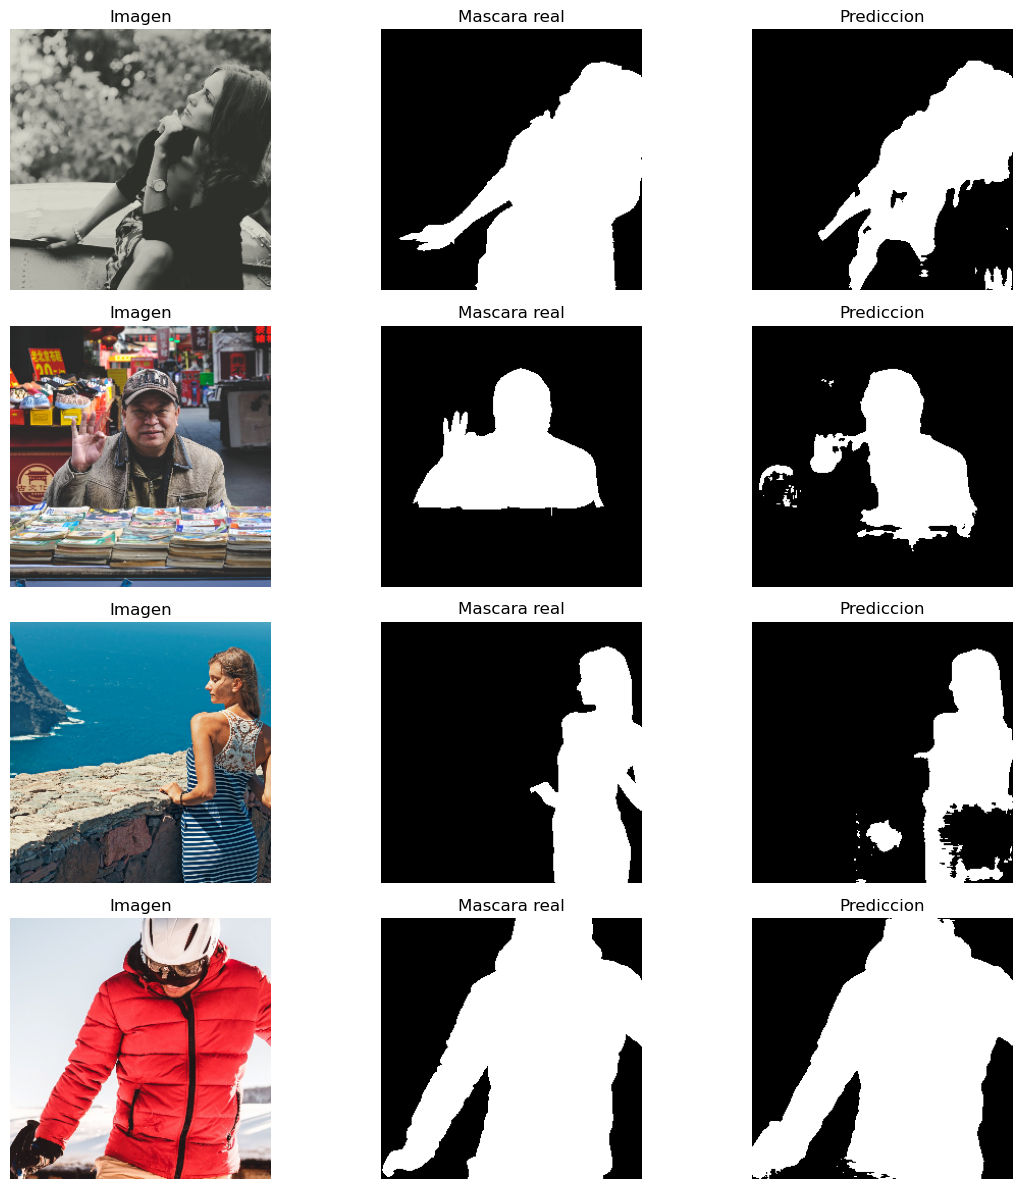

In [14]:
visualizar_predicciones(model, val_loader, device, "best_unet.pth", n_show=4)

### Entrenamiento 2 con U-Net v2
Segunda version del modelo con dropout, con activacion ReLu y kaiming para iniciacion de pesos. Kaiming se empareja bien con activaciones ReLu.

In [15]:
model = UNet_2(
    n_channels=3,
    n_classes=1,
    base_channels=64,
    bilinear=True,
    activation="relu",
    use_dropout=True,
    weight_init="kaiming",
).to(device)

print(model.__class__.__name__, "creado en", device)

UNet_2 creado en cuda


In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_2 = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=30,
    best_model_path="best_unet_2.pth"
)

  3%|▎         | 1/30 [02:35<1:15:12, 155.60s/it]

Epoch 1/30 | Train Loss: 0.6712 | Train Dice: 0.4559 | Val Loss: 0.6410 | Val Dice: 0.1337
  --> Nuevo mejor modelo guardado con Val Dice: 0.1337


  7%|▋         | 2/30 [05:10<1:12:30, 155.37s/it]

Epoch 2/30 | Train Loss: 0.6041 | Train Dice: 0.5311 | Val Loss: 0.5976 | Val Dice: 0.1819
  --> Nuevo mejor modelo guardado con Val Dice: 0.1819


 10%|█         | 3/30 [07:45<1:09:49, 155.18s/it]

Epoch 3/30 | Train Loss: 0.5699 | Train Dice: 0.5834 | Val Loss: 0.6692 | Val Dice: 0.1599


 13%|█▎        | 4/30 [10:20<1:07:12, 155.11s/it]

Epoch 4/30 | Train Loss: 0.5568 | Train Dice: 0.6061 | Val Loss: 0.6107 | Val Dice: 0.1031


 17%|█▋        | 5/30 [12:55<1:04:32, 154.92s/it]

Epoch 5/30 | Train Loss: 0.5327 | Train Dice: 0.6388 | Val Loss: 0.6329 | Val Dice: 0.1383


 20%|██        | 6/30 [15:30<1:01:59, 154.97s/it]

Epoch 6/30 | Train Loss: 0.5331 | Train Dice: 0.6417 | Val Loss: 0.7045 | Val Dice: 0.1690


 23%|██▎       | 7/30 [18:05<59:25, 155.03s/it]  

Epoch 7/30 | Train Loss: 0.5239 | Train Dice: 0.6542 | Val Loss: 0.6457 | Val Dice: 0.1663


 27%|██▋       | 8/30 [20:40<56:52, 155.10s/it]

Epoch 8/30 | Train Loss: 0.5152 | Train Dice: 0.6603 | Val Loss: 0.5940 | Val Dice: 0.3311
  --> Nuevo mejor modelo guardado con Val Dice: 0.3311


 30%|███       | 9/30 [23:15<54:16, 155.06s/it]

Epoch 9/30 | Train Loss: 0.5101 | Train Dice: 0.6696 | Val Loss: 0.7135 | Val Dice: 0.2170


 33%|███▎      | 10/30 [25:50<51:40, 155.00s/it]

Epoch 10/30 | Train Loss: 0.5056 | Train Dice: 0.6715 | Val Loss: 0.5881 | Val Dice: 0.4134
  --> Nuevo mejor modelo guardado con Val Dice: 0.4134


 37%|███▋      | 11/30 [28:25<49:06, 155.07s/it]

Epoch 11/30 | Train Loss: 0.5025 | Train Dice: 0.6763 | Val Loss: 0.5894 | Val Dice: 0.4473
  --> Nuevo mejor modelo guardado con Val Dice: 0.4473


 40%|████      | 12/30 [31:01<46:32, 155.17s/it]

Epoch 12/30 | Train Loss: 0.4967 | Train Dice: 0.6791 | Val Loss: 0.5301 | Val Dice: 0.5360
  --> Nuevo mejor modelo guardado con Val Dice: 0.5360


 43%|████▎     | 13/30 [33:36<43:58, 155.22s/it]

Epoch 13/30 | Train Loss: 0.4898 | Train Dice: 0.6847 | Val Loss: 0.5684 | Val Dice: 0.5252


 47%|████▋     | 14/30 [36:11<41:21, 155.11s/it]

Epoch 14/30 | Train Loss: 0.4829 | Train Dice: 0.6900 | Val Loss: 0.5652 | Val Dice: 0.5113


 50%|█████     | 15/30 [38:46<38:47, 155.18s/it]

Epoch 15/30 | Train Loss: 0.4742 | Train Dice: 0.6951 | Val Loss: 0.5300 | Val Dice: 0.5765
  --> Nuevo mejor modelo guardado con Val Dice: 0.5765


 53%|█████▎    | 16/30 [41:22<36:13, 155.23s/it]

Epoch 16/30 | Train Loss: 0.4758 | Train Dice: 0.6930 | Val Loss: 0.4979 | Val Dice: 0.6118
  --> Nuevo mejor modelo guardado con Val Dice: 0.6118


 57%|█████▋    | 17/30 [43:57<33:38, 155.24s/it]

Epoch 17/30 | Train Loss: 0.4697 | Train Dice: 0.6980 | Val Loss: 0.4355 | Val Dice: 0.7036
  --> Nuevo mejor modelo guardado con Val Dice: 0.7036


 60%|██████    | 18/30 [46:33<31:04, 155.40s/it]

Epoch 18/30 | Train Loss: 0.4632 | Train Dice: 0.7021 | Val Loss: 0.4382 | Val Dice: 0.7145
  --> Nuevo mejor modelo guardado con Val Dice: 0.7145


 63%|██████▎   | 19/30 [49:08<28:29, 155.44s/it]

Epoch 19/30 | Train Loss: 0.4650 | Train Dice: 0.7033 | Val Loss: 0.4732 | Val Dice: 0.6365


 67%|██████▋   | 20/30 [51:44<25:55, 155.50s/it]

Epoch 20/30 | Train Loss: 0.4591 | Train Dice: 0.7058 | Val Loss: 0.4347 | Val Dice: 0.6831


 70%|███████   | 21/30 [54:19<23:19, 155.46s/it]

Epoch 21/30 | Train Loss: 0.4530 | Train Dice: 0.7118 | Val Loss: 0.4609 | Val Dice: 0.6555


 73%|███████▎  | 22/30 [56:55<20:44, 155.55s/it]

Epoch 22/30 | Train Loss: 0.4542 | Train Dice: 0.7088 | Val Loss: 0.4497 | Val Dice: 0.6881


 77%|███████▋  | 23/30 [59:30<18:08, 155.44s/it]

Epoch 23/30 | Train Loss: 0.4470 | Train Dice: 0.7160 | Val Loss: 0.4433 | Val Dice: 0.6973


 80%|████████  | 24/30 [1:02:06<15:32, 155.42s/it]

Epoch 24/30 | Train Loss: 0.4477 | Train Dice: 0.7159 | Val Loss: 0.4364 | Val Dice: 0.6978


 83%|████████▎ | 25/30 [1:04:41<12:57, 155.55s/it]

Epoch 25/30 | Train Loss: 0.4451 | Train Dice: 0.7153 | Val Loss: 0.4407 | Val Dice: 0.6795


 87%|████████▋ | 26/30 [1:07:19<10:24, 156.09s/it]

Epoch 26/30 | Train Loss: 0.4396 | Train Dice: 0.7230 | Val Loss: 0.3899 | Val Dice: 0.7412
  --> Nuevo mejor modelo guardado con Val Dice: 0.7412


 90%|█████████ | 27/30 [1:09:56<07:49, 156.38s/it]

Epoch 27/30 | Train Loss: 0.4341 | Train Dice: 0.7246 | Val Loss: 0.4195 | Val Dice: 0.6897


 93%|█████████▎| 28/30 [1:12:34<05:13, 156.82s/it]

Epoch 28/30 | Train Loss: 0.4337 | Train Dice: 0.7223 | Val Loss: 0.3873 | Val Dice: 0.7422
  --> Nuevo mejor modelo guardado con Val Dice: 0.7422


 97%|█████████▋| 29/30 [1:15:11<02:37, 157.11s/it]

Epoch 29/30 | Train Loss: 0.4356 | Train Dice: 0.7228 | Val Loss: 0.3787 | Val Dice: 0.7507
  --> Nuevo mejor modelo guardado con Val Dice: 0.7507


100%|██████████| 30/30 [1:17:49<00:00, 155.66s/it]

Epoch 30/30 | Train Loss: 0.4331 | Train Dice: 0.7256 | Val Loss: 0.4230 | Val Dice: 0.6915


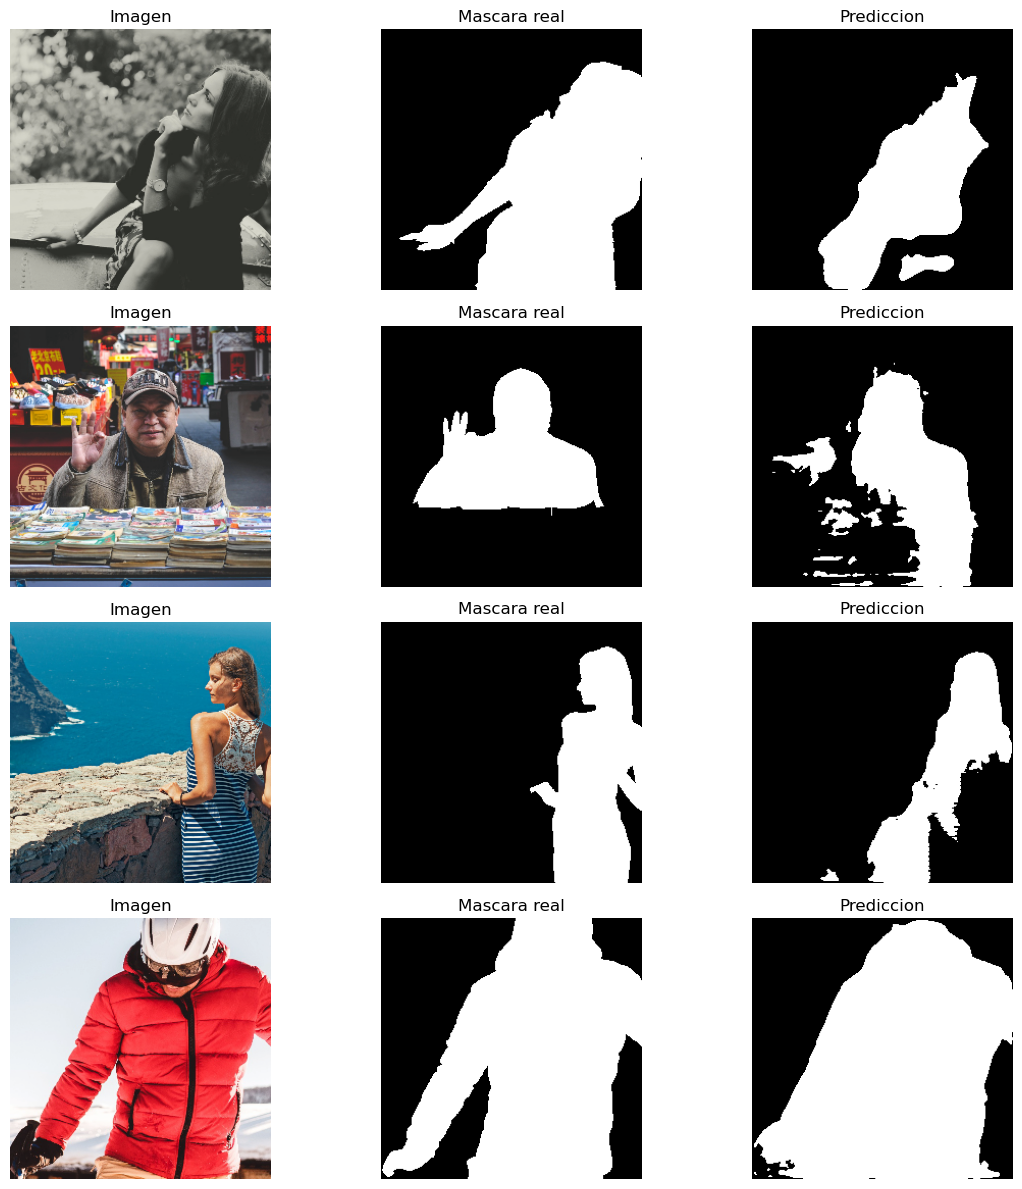

In [17]:
visualizar_predicciones(model, val_loader, device, "best_unet_2.pth", n_show=4)

### Entrenamiento 3 con Unet v2
Segunda version del modelo, sin dropout, con activacion ReLu y kaiming para iniciacion de pesos. Y con tamaño base de filtros igual 128.

In [18]:
model = UNet_2(
    n_channels=3,
    n_classes=1,
    base_channels=128,
    bilinear=True,
    activation="relu",
    use_dropout=False,
    weight_init="kaiming",
).to(device)

print(model.__class__.__name__, "creado en", device)

UNet_2 creado en cuda


In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_3 = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=30,
    best_model_path="best_unet_3.pth"
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 0.5422 | Train Dice: 0.6201 | Val Loss: 0.5316 | Val Dice: 0.5804


  3%|▎         | 1/30 [11:59<5:47:54, 719.82s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.5804
Epoch 2/30 | Train Loss: 0.4535 | Train Dice: 0.7000 | Val Loss: 0.4187 | Val Dice: 0.6606


  7%|▋         | 2/30 [23:57<5:35:27, 718.84s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.6606
Epoch 3/30 | Train Loss: 0.4116 | Train Dice: 0.7325 | Val Loss: 0.3880 | Val Dice: 0.7349


 10%|█         | 3/30 [35:58<5:23:45, 719.48s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.7349
Epoch 4/30 | Train Loss: 0.3802 | Train Dice: 0.7569 | Val Loss: 0.3403 | Val Dice: 0.7672


 13%|█▎        | 4/30 [47:56<5:11:29, 718.84s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.7672
Epoch 5/30 | Train Loss: 0.3642 | Train Dice: 0.7687 | Val Loss: 0.3306 | Val Dice: 0.7964


 17%|█▋        | 5/30 [59:54<4:59:29, 718.80s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.7964
Epoch 6/30 | Train Loss: 0.3381 | Train Dice: 0.7871 | Val Loss: 0.3105 | Val Dice: 0.8109


 20%|██        | 6/30 [1:11:53<4:47:29, 718.71s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8109
Epoch 7/30 | Train Loss: 0.3294 | Train Dice: 0.7949 | Val Loss: 0.2938 | Val Dice: 0.8169


 23%|██▎       | 7/30 [1:23:58<4:36:19, 720.87s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8169
Epoch 8/30 | Train Loss: 0.3037 | Train Dice: 0.8119 | Val Loss: 0.2775 | Val Dice: 0.8198


 27%|██▋       | 8/30 [1:35:59<4:24:21, 720.96s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8198
Epoch 9/30 | Train Loss: 0.2905 | Train Dice: 0.8216 | Val Loss: 0.2646 | Val Dice: 0.8375


 30%|███       | 9/30 [1:48:00<4:12:17, 720.85s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8375


 33%|███▎      | 10/30 [1:59:58<3:59:59, 719.95s/it]

Epoch 10/30 | Train Loss: 0.2776 | Train Dice: 0.8331 | Val Loss: 0.2567 | Val Dice: 0.8355
Epoch 11/30 | Train Loss: 0.2602 | Train Dice: 0.8394 | Val Loss: 0.2579 | Val Dice: 0.8473


 37%|███▋      | 11/30 [2:11:55<3:47:42, 719.07s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8473


 40%|████      | 12/30 [2:23:52<3:35:31, 718.40s/it]

Epoch 12/30 | Train Loss: 0.2396 | Train Dice: 0.8536 | Val Loss: 0.2550 | Val Dice: 0.8438


 43%|████▎     | 13/30 [2:35:48<3:23:21, 717.71s/it]

Epoch 13/30 | Train Loss: 0.2325 | Train Dice: 0.8551 | Val Loss: 0.2732 | Val Dice: 0.8402
Epoch 14/30 | Train Loss: 0.2126 | Train Dice: 0.8684 | Val Loss: 0.2238 | Val Dice: 0.8621


 47%|████▋     | 14/30 [2:47:45<3:11:21, 717.62s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8621
Epoch 15/30 | Train Loss: 0.2078 | Train Dice: 0.8723 | Val Loss: 0.2123 | Val Dice: 0.8645


 50%|█████     | 15/30 [2:59:42<2:59:21, 717.41s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8645
Epoch 16/30 | Train Loss: 0.1894 | Train Dice: 0.8826 | Val Loss: 0.2214 | Val Dice: 0.8655


 53%|█████▎    | 16/30 [3:11:40<2:47:24, 717.44s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8655


 57%|█████▋    | 17/30 [3:23:36<2:35:23, 717.23s/it]

Epoch 17/30 | Train Loss: 0.1829 | Train Dice: 0.8857 | Val Loss: 0.2135 | Val Dice: 0.8544
Epoch 18/30 | Train Loss: 0.1698 | Train Dice: 0.8919 | Val Loss: 0.2094 | Val Dice: 0.8754


 60%|██████    | 18/30 [3:35:34<2:23:26, 717.17s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8754


 63%|██████▎   | 19/30 [3:47:31<2:11:29, 717.24s/it]

Epoch 19/30 | Train Loss: 0.1555 | Train Dice: 0.9023 | Val Loss: 0.2121 | Val Dice: 0.8646
Epoch 20/30 | Train Loss: 0.1518 | Train Dice: 0.9046 | Val Loss: 0.1950 | Val Dice: 0.8785


 67%|██████▋   | 20/30 [3:59:30<1:59:37, 717.78s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8785


 70%|███████   | 21/30 [4:11:25<1:47:32, 716.93s/it]

Epoch 21/30 | Train Loss: 0.1394 | Train Dice: 0.9108 | Val Loss: 0.2185 | Val Dice: 0.8740


 73%|███████▎  | 22/30 [4:23:20<1:35:32, 716.50s/it]

Epoch 22/30 | Train Loss: 0.1348 | Train Dice: 0.9156 | Val Loss: 0.2187 | Val Dice: 0.8723
Epoch 23/30 | Train Loss: 0.1245 | Train Dice: 0.9201 | Val Loss: 0.1831 | Val Dice: 0.8839


 77%|███████▋  | 23/30 [4:35:20<1:23:41, 717.40s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8839


 80%|████████  | 24/30 [4:47:15<1:11:40, 716.79s/it]

Epoch 24/30 | Train Loss: 0.1087 | Train Dice: 0.9297 | Val Loss: 0.2005 | Val Dice: 0.8685


 83%|████████▎ | 25/30 [4:59:12<59:44, 716.82s/it]  

Epoch 25/30 | Train Loss: 0.1008 | Train Dice: 0.9347 | Val Loss: 0.2236 | Val Dice: 0.8765


 87%|████████▋ | 26/30 [5:11:08<47:46, 716.63s/it]

Epoch 26/30 | Train Loss: 0.0928 | Train Dice: 0.9400 | Val Loss: 0.1976 | Val Dice: 0.8712
Epoch 27/30 | Train Loss: 0.0835 | Train Dice: 0.9451 | Val Loss: 0.1856 | Val Dice: 0.8862


 90%|█████████ | 27/30 [5:23:06<35:50, 716.84s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8862
Epoch 28/30 | Train Loss: 0.0773 | Train Dice: 0.9482 | Val Loss: 0.2009 | Val Dice: 0.8888


 93%|█████████▎| 28/30 [5:35:03<23:53, 716.99s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8888
Epoch 29/30 | Train Loss: 0.0678 | Train Dice: 0.9544 | Val Loss: 0.2072 | Val Dice: 0.8895


 97%|█████████▋| 29/30 [5:47:00<11:57, 717.07s/it]

  --> Nuevo mejor modelo guardado con Val Dice: 0.8895


100%|██████████| 30/30 [5:58:57<00:00, 717.93s/it]

Epoch 30/30 | Train Loss: 0.0604 | Train Dice: 0.9582 | Val Loss: 0.2193 | Val Dice: 0.8864


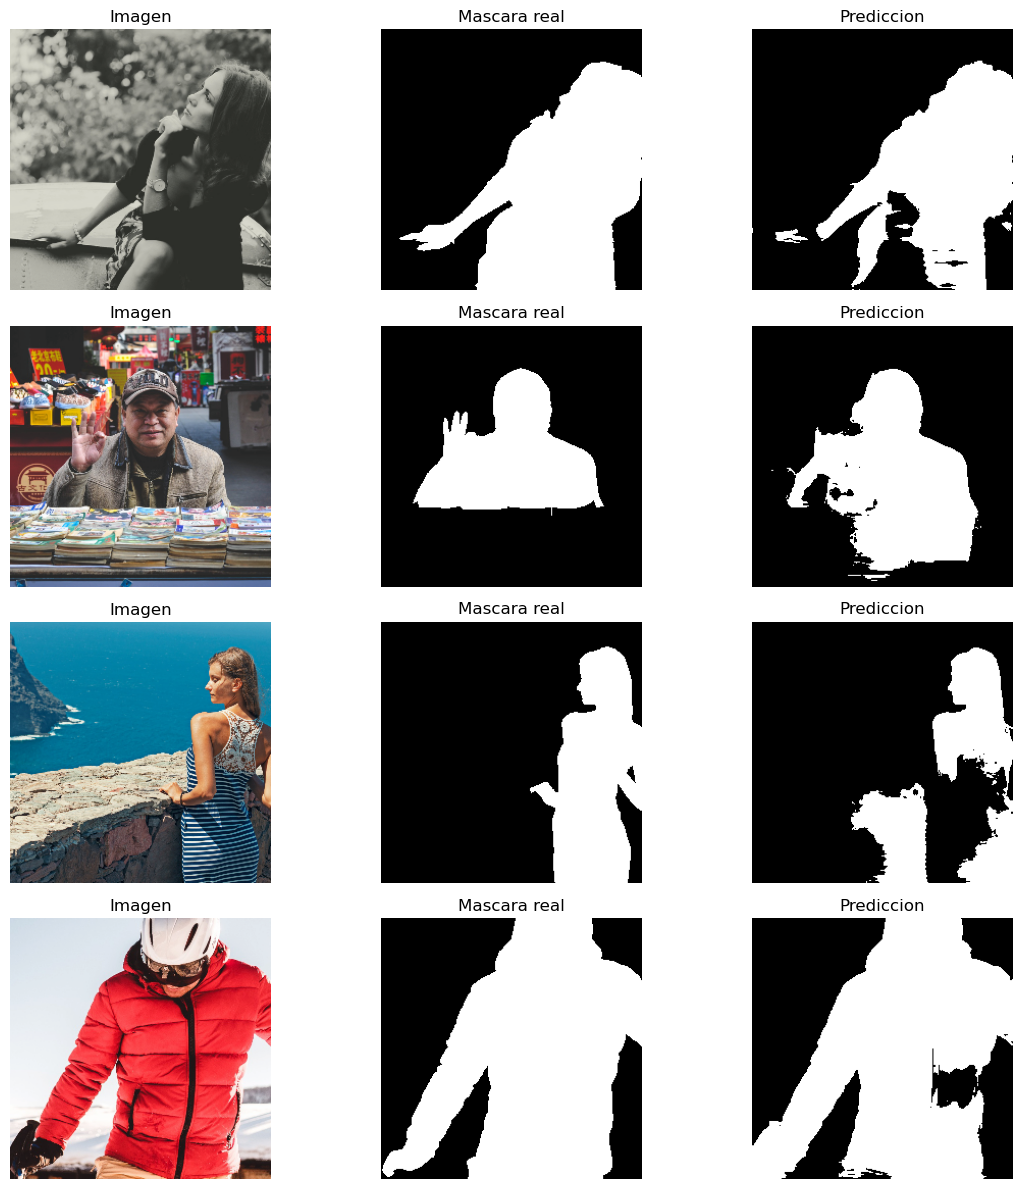

In [20]:
visualizar_predicciones(model, val_loader, device, "best_unet_3.pth", n_show=4)

### Entrenamiento 4 con Unet v2
Con modelo de 4 capas, sin dropout, con activacion ReLu y kaiming para iniciacion de pesos. Y con tamaño base de filtros igual a 32.

In [21]:
model = UNet_2(
    n_channels=3,
    n_classes=1,
    base_channels=32,
    bilinear=True,
    activation="relu",
    use_dropout=False,
    weight_init="kaiming",
).to(device)

print(model.__class__.__name__, "creado en", device)

UNet_2 creado en cuda


In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_4 = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=30,
    best_model_path="best_unet_4.pth"
)

  3%|▎         | 1/30 [01:26<41:59, 86.86s/it]

Epoch 1/30 | Train Loss: 0.5117 | Train Dice: 0.6480 | Val Loss: 0.4378 | Val Dice: 0.6741
  --> Nuevo mejor modelo guardado con Val Dice: 0.6741


  7%|▋         | 2/30 [02:52<40:11, 86.13s/it]

Epoch 2/30 | Train Loss: 0.4213 | Train Dice: 0.7228 | Val Loss: 0.4881 | Val Dice: 0.5913


 10%|█         | 3/30 [04:20<39:04, 86.84s/it]

Epoch 3/30 | Train Loss: 0.3783 | Train Dice: 0.7613 | Val Loss: 0.3730 | Val Dice: 0.7674
  --> Nuevo mejor modelo guardado con Val Dice: 0.7674


 13%|█▎        | 4/30 [05:46<37:33, 86.66s/it]

Epoch 4/30 | Train Loss: 0.3429 | Train Dice: 0.7867 | Val Loss: 0.3039 | Val Dice: 0.7973
  --> Nuevo mejor modelo guardado con Val Dice: 0.7973


 17%|█▋        | 5/30 [07:12<35:57, 86.32s/it]

Epoch 5/30 | Train Loss: 0.3134 | Train Dice: 0.8067 | Val Loss: 0.2738 | Val Dice: 0.8294
  --> Nuevo mejor modelo guardado con Val Dice: 0.8294


 20%|██        | 6/30 [08:37<34:20, 85.84s/it]

Epoch 6/30 | Train Loss: 0.2919 | Train Dice: 0.8215 | Val Loss: 0.3061 | Val Dice: 0.7870


 23%|██▎       | 7/30 [10:02<32:47, 85.56s/it]

Epoch 7/30 | Train Loss: 0.2827 | Train Dice: 0.8276 | Val Loss: 0.2478 | Val Dice: 0.8471
  --> Nuevo mejor modelo guardado con Val Dice: 0.8471


 27%|██▋       | 8/30 [11:27<31:21, 85.51s/it]

Epoch 8/30 | Train Loss: 0.2535 | Train Dice: 0.8440 | Val Loss: 0.2691 | Val Dice: 0.8375


 30%|███       | 9/30 [12:52<29:53, 85.38s/it]

Epoch 9/30 | Train Loss: 0.2425 | Train Dice: 0.8541 | Val Loss: 0.2327 | Val Dice: 0.8575
  --> Nuevo mejor modelo guardado con Val Dice: 0.8575


 33%|███▎      | 10/30 [14:18<28:30, 85.52s/it]

Epoch 10/30 | Train Loss: 0.2284 | Train Dice: 0.8595 | Val Loss: 0.2096 | Val Dice: 0.8696
  --> Nuevo mejor modelo guardado con Val Dice: 0.8696


 37%|███▋      | 11/30 [15:43<27:04, 85.48s/it]

Epoch 11/30 | Train Loss: 0.2042 | Train Dice: 0.8745 | Val Loss: 0.2121 | Val Dice: 0.8670


 40%|████      | 12/30 [17:09<25:38, 85.49s/it]

Epoch 12/30 | Train Loss: 0.1980 | Train Dice: 0.8786 | Val Loss: 0.2263 | Val Dice: 0.8625


 43%|████▎     | 13/30 [18:34<24:10, 85.32s/it]

Epoch 13/30 | Train Loss: 0.1861 | Train Dice: 0.8823 | Val Loss: 0.2165 | Val Dice: 0.8633


 47%|████▋     | 14/30 [19:59<22:44, 85.31s/it]

Epoch 14/30 | Train Loss: 0.1713 | Train Dice: 0.8937 | Val Loss: 0.1962 | Val Dice: 0.8766
  --> Nuevo mejor modelo guardado con Val Dice: 0.8766


 50%|█████     | 15/30 [21:25<21:21, 85.46s/it]

Epoch 15/30 | Train Loss: 0.1598 | Train Dice: 0.9017 | Val Loss: 0.2114 | Val Dice: 0.8748


 53%|█████▎    | 16/30 [22:50<19:55, 85.38s/it]

Epoch 16/30 | Train Loss: 0.1498 | Train Dice: 0.9042 | Val Loss: 0.1906 | Val Dice: 0.8840
  --> Nuevo mejor modelo guardado con Val Dice: 0.8840


 57%|█████▋    | 17/30 [24:16<18:31, 85.53s/it]

Epoch 17/30 | Train Loss: 0.1358 | Train Dice: 0.9135 | Val Loss: 0.1911 | Val Dice: 0.8794


 60%|██████    | 18/30 [25:41<17:05, 85.43s/it]

Epoch 18/30 | Train Loss: 0.1387 | Train Dice: 0.9133 | Val Loss: 0.1781 | Val Dice: 0.8892
  --> Nuevo mejor modelo guardado con Val Dice: 0.8892


 63%|██████▎   | 19/30 [27:06<15:38, 85.30s/it]

Epoch 19/30 | Train Loss: 0.1232 | Train Dice: 0.9208 | Val Loss: 0.1986 | Val Dice: 0.8830


 67%|██████▋   | 20/30 [28:31<14:12, 85.23s/it]

Epoch 20/30 | Train Loss: 0.1191 | Train Dice: 0.9244 | Val Loss: 0.1873 | Val Dice: 0.8804


 70%|███████   | 21/30 [29:57<12:47, 85.28s/it]

Epoch 21/30 | Train Loss: 0.1052 | Train Dice: 0.9314 | Val Loss: 0.1810 | Val Dice: 0.8912
  --> Nuevo mejor modelo guardado con Val Dice: 0.8912


 73%|███████▎  | 22/30 [31:22<11:21, 85.22s/it]

Epoch 22/30 | Train Loss: 0.0911 | Train Dice: 0.9394 | Val Loss: 0.1814 | Val Dice: 0.8927
  --> Nuevo mejor modelo guardado con Val Dice: 0.8927


 77%|███████▋  | 23/30 [32:47<09:55, 85.13s/it]

Epoch 23/30 | Train Loss: 0.0867 | Train Dice: 0.9420 | Val Loss: 0.1806 | Val Dice: 0.8917


 80%|████████  | 24/30 [34:12<08:31, 85.29s/it]

Epoch 24/30 | Train Loss: 0.0790 | Train Dice: 0.9470 | Val Loss: 0.1969 | Val Dice: 0.8923


 83%|████████▎ | 25/30 [35:37<07:06, 85.20s/it]

Epoch 25/30 | Train Loss: 0.0786 | Train Dice: 0.9482 | Val Loss: 0.1949 | Val Dice: 0.8853


 87%|████████▋ | 26/30 [37:03<05:41, 85.41s/it]

Epoch 26/30 | Train Loss: 0.0731 | Train Dice: 0.9515 | Val Loss: 0.1986 | Val Dice: 0.8893


 90%|█████████ | 27/30 [38:28<04:15, 85.29s/it]

Epoch 27/30 | Train Loss: 0.0742 | Train Dice: 0.9505 | Val Loss: 0.1740 | Val Dice: 0.9000
  --> Nuevo mejor modelo guardado con Val Dice: 0.9000


 93%|█████████▎| 28/30 [39:53<02:50, 85.22s/it]

Epoch 28/30 | Train Loss: 0.0699 | Train Dice: 0.9541 | Val Loss: 0.1866 | Val Dice: 0.8888


 97%|█████████▋| 29/30 [41:18<01:25, 85.12s/it]

Epoch 29/30 | Train Loss: 0.0696 | Train Dice: 0.9536 | Val Loss: 0.1921 | Val Dice: 0.8953


100%|██████████| 30/30 [42:44<00:00, 85.47s/it]

Epoch 30/30 | Train Loss: 0.0485 | Train Dice: 0.9664 | Val Loss: 0.2141 | Val Dice: 0.8867


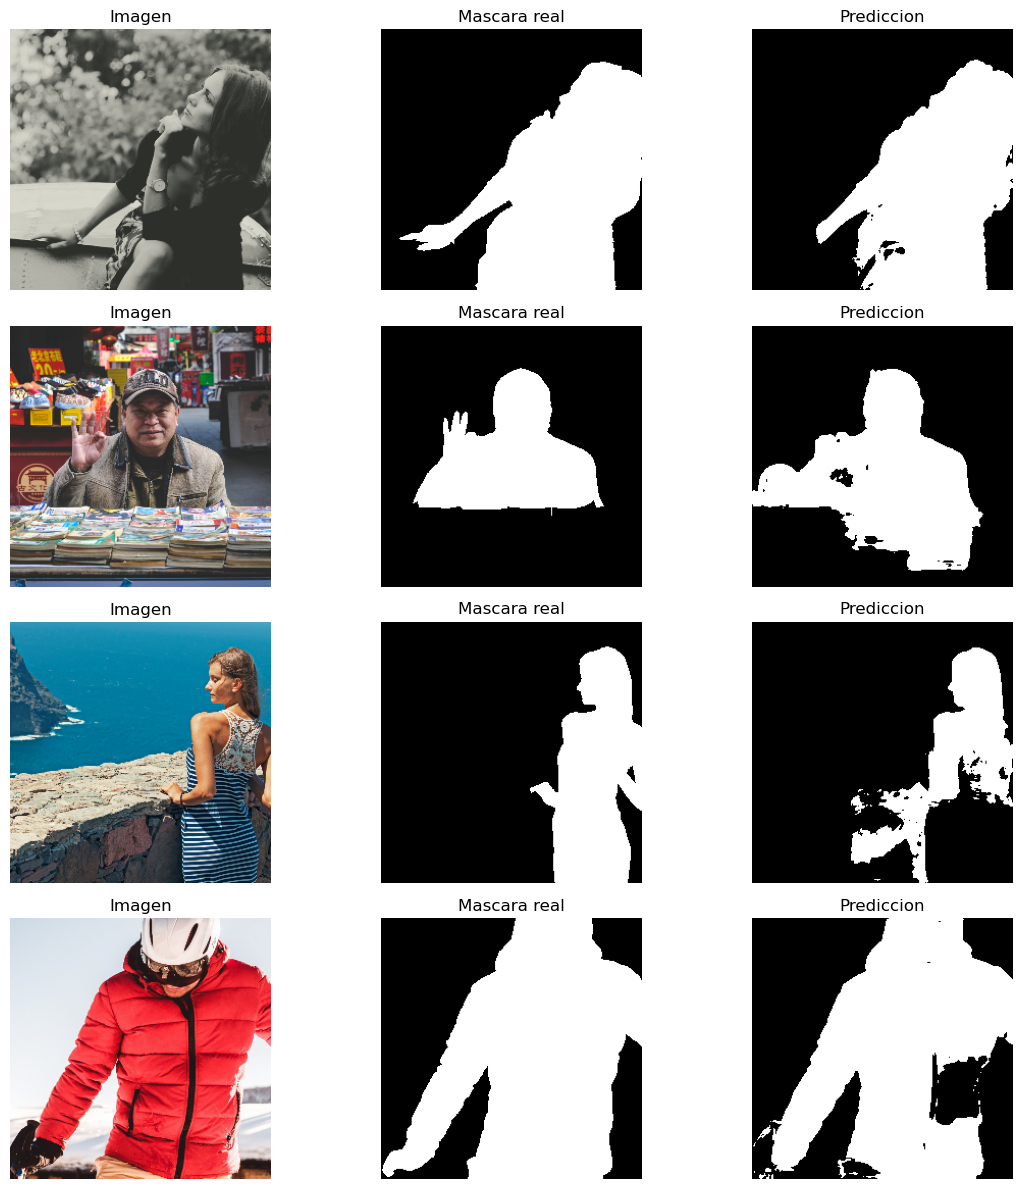

In [23]:
visualizar_predicciones(model, val_loader, device, "best_unet_4.pth", n_show=4)

### Entrenamiento 5 con Unet_2
Segunda version del modelo, sin dropout, con activacion ReLu y kaiming para iniciacion de pesos. Volviendo al tamaño de filtros del paper, igual a 64.

In [24]:
model = UNet_2(
    n_channels=3,
    n_classes=1,
    base_channels=64,
    bilinear=True,
    activation="relu",
    use_dropout=False,
    weight_init="kaiming",
).to(device)

print(model.__class__.__name__, "creado en", device)

UNet_2 creado en cuda


In [25]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_5 = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=30,
    best_model_path="best_unet_5.pth"
)

  3%|▎         | 1/30 [02:30<1:12:41, 150.40s/it]

Epoch 1/30 | Train Loss: 0.5506 | Train Dice: 0.6223 | Val Loss: 0.5153 | Val Dice: 0.6367
  --> Nuevo mejor modelo guardado con Val Dice: 0.6367


  7%|▋         | 2/30 [05:03<1:10:59, 152.14s/it]

Epoch 2/30 | Train Loss: 0.4736 | Train Dice: 0.6847 | Val Loss: 0.4283 | Val Dice: 0.7314
  --> Nuevo mejor modelo guardado con Val Dice: 0.7314


 10%|█         | 3/30 [07:35<1:08:27, 152.11s/it]

Epoch 3/30 | Train Loss: 0.4255 | Train Dice: 0.7281 | Val Loss: 0.3782 | Val Dice: 0.7503
  --> Nuevo mejor modelo guardado con Val Dice: 0.7503


 13%|█▎        | 4/30 [10:07<1:05:54, 152.10s/it]

Epoch 4/30 | Train Loss: 0.3855 | Train Dice: 0.7575 | Val Loss: 0.3781 | Val Dice: 0.7730
  --> Nuevo mejor modelo guardado con Val Dice: 0.7730


 17%|█▋        | 5/30 [12:40<1:03:26, 152.28s/it]

Epoch 5/30 | Train Loss: 0.3643 | Train Dice: 0.7722 | Val Loss: 0.3312 | Val Dice: 0.8070
  --> Nuevo mejor modelo guardado con Val Dice: 0.8070


 20%|██        | 6/30 [15:12<1:00:53, 152.23s/it]

Epoch 6/30 | Train Loss: 0.3396 | Train Dice: 0.7866 | Val Loss: 0.2950 | Val Dice: 0.8132
  --> Nuevo mejor modelo guardado con Val Dice: 0.8132


 23%|██▎       | 7/30 [17:44<58:18, 152.10s/it]  

Epoch 7/30 | Train Loss: 0.3194 | Train Dice: 0.8015 | Val Loss: 0.3275 | Val Dice: 0.7987


 27%|██▋       | 8/30 [20:16<55:47, 152.17s/it]

Epoch 8/30 | Train Loss: 0.3017 | Train Dice: 0.8159 | Val Loss: 0.2923 | Val Dice: 0.8034


 30%|███       | 9/30 [22:49<53:19, 152.38s/it]

Epoch 9/30 | Train Loss: 0.2845 | Train Dice: 0.8251 | Val Loss: 0.2619 | Val Dice: 0.8425
  --> Nuevo mejor modelo guardado con Val Dice: 0.8425


 33%|███▎      | 10/30 [25:21<50:47, 152.35s/it]

Epoch 10/30 | Train Loss: 0.2711 | Train Dice: 0.8335 | Val Loss: 0.2550 | Val Dice: 0.8472
  --> Nuevo mejor modelo guardado con Val Dice: 0.8472


 37%|███▋      | 11/30 [27:59<48:42, 153.81s/it]

Epoch 11/30 | Train Loss: 0.2545 | Train Dice: 0.8445 | Val Loss: 0.2489 | Val Dice: 0.8521
  --> Nuevo mejor modelo guardado con Val Dice: 0.8521


 40%|████      | 12/30 [30:30<45:57, 153.22s/it]

Epoch 12/30 | Train Loss: 0.2412 | Train Dice: 0.8533 | Val Loss: 0.2282 | Val Dice: 0.8537
  --> Nuevo mejor modelo guardado con Val Dice: 0.8537


 43%|████▎     | 13/30 [33:02<43:17, 152.77s/it]

Epoch 13/30 | Train Loss: 0.2265 | Train Dice: 0.8602 | Val Loss: 0.2419 | Val Dice: 0.8350


 47%|████▋     | 14/30 [35:35<40:44, 152.77s/it]

Epoch 14/30 | Train Loss: 0.2123 | Train Dice: 0.8684 | Val Loss: 0.2444 | Val Dice: 0.8384


 50%|█████     | 15/30 [38:31<39:56, 159.74s/it]

Epoch 15/30 | Train Loss: 0.2006 | Train Dice: 0.8764 | Val Loss: 0.2109 | Val Dice: 0.8674
  --> Nuevo mejor modelo guardado con Val Dice: 0.8674


 53%|█████▎    | 16/30 [40:57<36:18, 155.59s/it]

Epoch 16/30 | Train Loss: 0.1930 | Train Dice: 0.8792 | Val Loss: 0.2029 | Val Dice: 0.8731
  --> Nuevo mejor modelo guardado con Val Dice: 0.8731


 57%|█████▋    | 17/30 [43:25<33:12, 153.28s/it]

Epoch 17/30 | Train Loss: 0.1797 | Train Dice: 0.8911 | Val Loss: 0.2609 | Val Dice: 0.8399


 60%|██████    | 18/30 [45:53<30:19, 151.66s/it]

Epoch 18/30 | Train Loss: 0.1711 | Train Dice: 0.8911 | Val Loss: 0.1921 | Val Dice: 0.8794
  --> Nuevo mejor modelo guardado con Val Dice: 0.8794


 63%|██████▎   | 19/30 [48:21<27:37, 150.65s/it]

Epoch 19/30 | Train Loss: 0.1599 | Train Dice: 0.9003 | Val Loss: 0.2012 | Val Dice: 0.8686


 67%|██████▋   | 20/30 [50:49<25:00, 150.00s/it]

Epoch 20/30 | Train Loss: 0.1467 | Train Dice: 0.9072 | Val Loss: 0.2124 | Val Dice: 0.8606


 70%|███████   | 21/30 [53:19<22:29, 149.98s/it]

Epoch 21/30 | Train Loss: 0.1415 | Train Dice: 0.9106 | Val Loss: 0.2090 | Val Dice: 0.8721


 73%|███████▎  | 22/30 [55:47<19:55, 149.38s/it]

Epoch 22/30 | Train Loss: 0.1257 | Train Dice: 0.9196 | Val Loss: 0.1899 | Val Dice: 0.8866
  --> Nuevo mejor modelo guardado con Val Dice: 0.8866


 77%|███████▋  | 23/30 [58:16<17:23, 149.09s/it]

Epoch 23/30 | Train Loss: 0.1259 | Train Dice: 0.9202 | Val Loss: 0.1894 | Val Dice: 0.8815


 80%|████████  | 24/30 [1:00:44<14:52, 148.82s/it]

Epoch 24/30 | Train Loss: 0.1106 | Train Dice: 0.9270 | Val Loss: 0.1866 | Val Dice: 0.8866


 83%|████████▎ | 25/30 [1:03:13<12:23, 148.77s/it]

Epoch 25/30 | Train Loss: 0.1010 | Train Dice: 0.9354 | Val Loss: 0.1931 | Val Dice: 0.8833


 87%|████████▋ | 26/30 [1:05:41<09:55, 148.75s/it]

Epoch 26/30 | Train Loss: 0.0954 | Train Dice: 0.9378 | Val Loss: 0.2226 | Val Dice: 0.8733


 90%|█████████ | 27/30 [1:08:10<07:26, 148.84s/it]

Epoch 27/30 | Train Loss: 0.0969 | Train Dice: 0.9389 | Val Loss: 0.1950 | Val Dice: 0.8833


 93%|█████████▎| 28/30 [1:10:39<04:57, 148.80s/it]

Epoch 28/30 | Train Loss: 0.0857 | Train Dice: 0.9441 | Val Loss: 0.2275 | Val Dice: 0.8758


 97%|█████████▋| 29/30 [1:13:07<02:28, 148.63s/it]

Epoch 29/30 | Train Loss: 0.0739 | Train Dice: 0.9517 | Val Loss: 0.2070 | Val Dice: 0.8838


100%|██████████| 30/30 [1:15:36<00:00, 151.21s/it]

Epoch 30/30 | Train Loss: 0.0659 | Train Dice: 0.9566 | Val Loss: 0.1937 | Val Dice: 0.8876
  --> Nuevo mejor modelo guardado con Val Dice: 0.8876


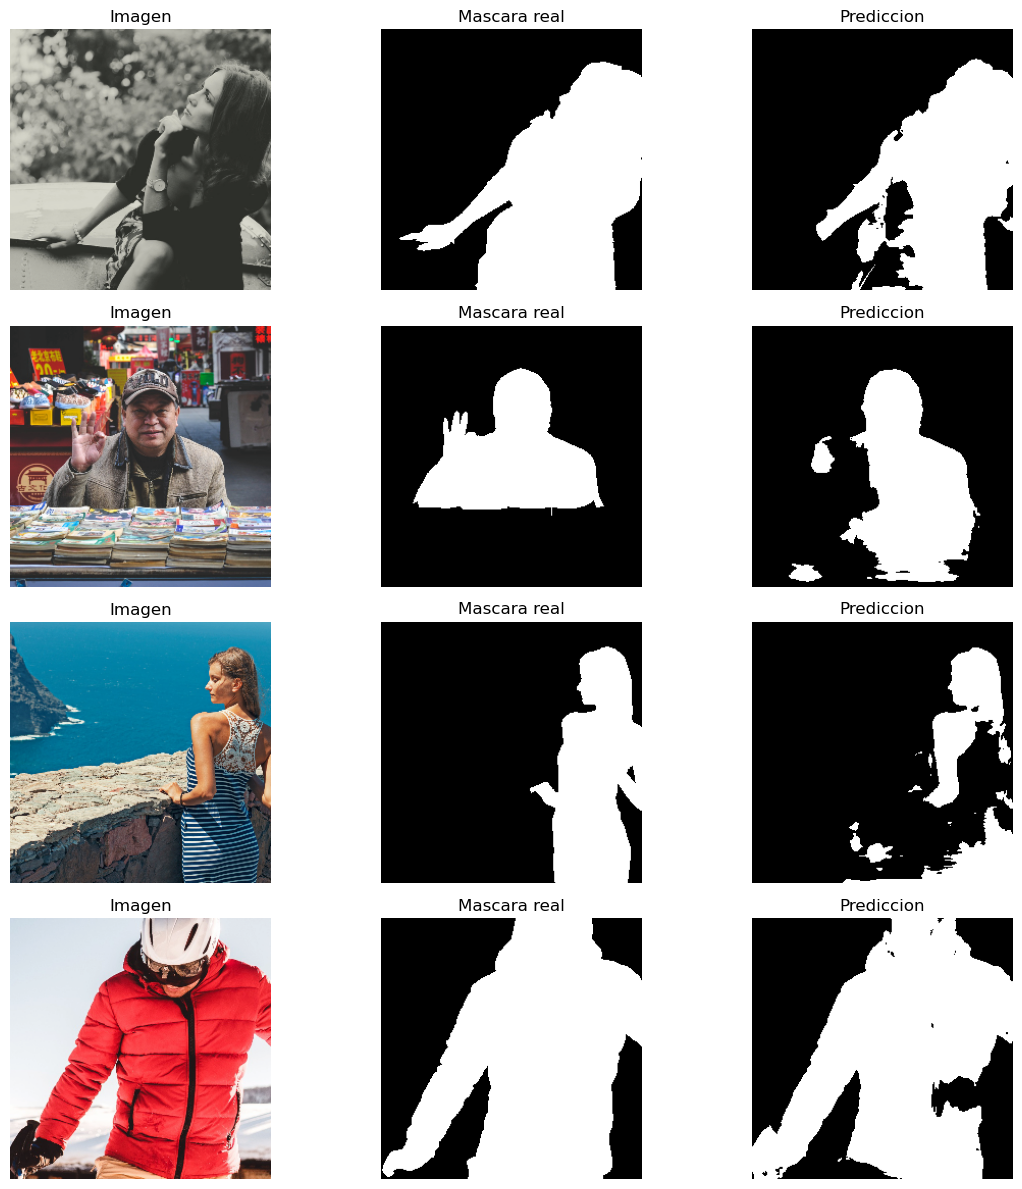

In [26]:
visualizar_predicciones(model, val_loader, device, checkpoint_path="best_unet_5.pth", n_show=4)

### Entrenamiento 6 con Unet_2
Commenzamos a probar con técnicas de DA. Con modelo Unet de 4 capas, sin dropout, con activacion ReLu y kaiming para iniciacion de pesos.

In [27]:
train_transform_DA = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=15,
        border_mode=0,  
        p=0.3
    ),
    # A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_dataset = SegmentationDataset(
    img_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform_DA,
    filenames=train_files
)

val_dataset = SegmentationDataset(
    img_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=val_transform,
    filenames=val_files
)

BATCH_SIZE = 4

train_w_DA_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

c:\Users\Octav\miniconda3\envs\taller_dl\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [28]:
model = UNet_2(
    n_channels=3,
    n_classes=1,
    base_channels=64,
    bilinear=True,
    activation="relu",
    use_dropout=False,
    weight_init="kaiming",
).to(device)

print(model.__class__.__name__, "creado en", device)

UNet_2 creado en cuda


In [29]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_6 = train(
    model=model,
    train_loader=train_w_DA_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=30,
    best_model_path="best_unet_6.pth"
)

  3%|▎         | 1/30 [02:28<1:11:49, 148.59s/it]

Epoch 1/30 | Train Loss: 0.5614 | Train Dice: 0.5699 | Val Loss: 0.5356 | Val Dice: 0.6440
  --> Nuevo mejor modelo guardado con Val Dice: 0.6440


  7%|▋         | 2/30 [04:57<1:09:21, 148.64s/it]

Epoch 2/30 | Train Loss: 0.5085 | Train Dice: 0.6427 | Val Loss: 0.4518 | Val Dice: 0.7111
  --> Nuevo mejor modelo guardado con Val Dice: 0.7111


 10%|█         | 3/30 [07:26<1:06:59, 148.87s/it]

Epoch 3/30 | Train Loss: 0.4623 | Train Dice: 0.6853 | Val Loss: 0.4179 | Val Dice: 0.7463
  --> Nuevo mejor modelo guardado con Val Dice: 0.7463


 13%|█▎        | 4/30 [10:28<1:10:09, 161.90s/it]

Epoch 4/30 | Train Loss: 0.4374 | Train Dice: 0.7097 | Val Loss: 0.3861 | Val Dice: 0.7671
  --> Nuevo mejor modelo guardado con Val Dice: 0.7671


 17%|█▋        | 5/30 [13:00<1:06:04, 158.56s/it]

Epoch 5/30 | Train Loss: 0.4036 | Train Dice: 0.7390 | Val Loss: 0.3566 | Val Dice: 0.7850
  --> Nuevo mejor modelo guardado con Val Dice: 0.7850


 20%|██        | 6/30 [15:29<1:02:03, 155.14s/it]

Epoch 6/30 | Train Loss: 0.3928 | Train Dice: 0.7461 | Val Loss: 0.3626 | Val Dice: 0.7920
  --> Nuevo mejor modelo guardado con Val Dice: 0.7920


 23%|██▎       | 7/30 [17:58<58:44, 153.25s/it]  

Epoch 7/30 | Train Loss: 0.3769 | Train Dice: 0.7570 | Val Loss: 0.3498 | Val Dice: 0.7355


 27%|██▋       | 8/30 [20:28<55:47, 152.15s/it]

Epoch 8/30 | Train Loss: 0.3634 | Train Dice: 0.7690 | Val Loss: 0.3235 | Val Dice: 0.8004
  --> Nuevo mejor modelo guardado con Val Dice: 0.8004


 30%|███       | 9/30 [22:58<52:58, 151.35s/it]

Epoch 9/30 | Train Loss: 0.3525 | Train Dice: 0.7766 | Val Loss: 0.3307 | Val Dice: 0.8096
  --> Nuevo mejor modelo guardado con Val Dice: 0.8096


 33%|███▎      | 10/30 [25:27<50:17, 150.86s/it]

Epoch 10/30 | Train Loss: 0.3367 | Train Dice: 0.7897 | Val Loss: 0.3335 | Val Dice: 0.7770


 37%|███▋      | 11/30 [27:57<47:37, 150.39s/it]

Epoch 11/30 | Train Loss: 0.3289 | Train Dice: 0.7903 | Val Loss: 0.2746 | Val Dice: 0.8242
  --> Nuevo mejor modelo guardado con Val Dice: 0.8242


 40%|████      | 12/30 [30:26<45:03, 150.19s/it]

Epoch 12/30 | Train Loss: 0.3163 | Train Dice: 0.8034 | Val Loss: 0.2594 | Val Dice: 0.8372
  --> Nuevo mejor modelo guardado con Val Dice: 0.8372


 43%|████▎     | 13/30 [32:56<42:28, 149.90s/it]

Epoch 13/30 | Train Loss: 0.3040 | Train Dice: 0.8112 | Val Loss: 0.2832 | Val Dice: 0.8329


 47%|████▋     | 14/30 [35:25<39:57, 149.82s/it]

Epoch 14/30 | Train Loss: 0.2914 | Train Dice: 0.8210 | Val Loss: 0.2775 | Val Dice: 0.8484
  --> Nuevo mejor modelo guardado con Val Dice: 0.8484


 50%|█████     | 15/30 [37:55<37:24, 149.65s/it]

Epoch 15/30 | Train Loss: 0.2861 | Train Dice: 0.8224 | Val Loss: 0.2602 | Val Dice: 0.8469


 53%|█████▎    | 16/30 [40:25<34:56, 149.77s/it]

Epoch 16/30 | Train Loss: 0.2816 | Train Dice: 0.8255 | Val Loss: 0.2600 | Val Dice: 0.8412


 57%|█████▋    | 17/30 [42:54<32:23, 149.52s/it]

Epoch 17/30 | Train Loss: 0.2679 | Train Dice: 0.8347 | Val Loss: 0.2526 | Val Dice: 0.8499
  --> Nuevo mejor modelo guardado con Val Dice: 0.8499


 60%|██████    | 18/30 [45:23<29:54, 149.51s/it]

Epoch 18/30 | Train Loss: 0.2705 | Train Dice: 0.8318 | Val Loss: 0.2446 | Val Dice: 0.8537
  --> Nuevo mejor modelo guardado con Val Dice: 0.8537


 63%|██████▎   | 19/30 [47:52<27:23, 149.40s/it]

Epoch 19/30 | Train Loss: 0.2557 | Train Dice: 0.8439 | Val Loss: 0.2379 | Val Dice: 0.8545
  --> Nuevo mejor modelo guardado con Val Dice: 0.8545


 67%|██████▋   | 20/30 [50:20<24:49, 148.92s/it]

Epoch 20/30 | Train Loss: 0.2495 | Train Dice: 0.8435 | Val Loss: 0.2099 | Val Dice: 0.8662
  --> Nuevo mejor modelo guardado con Val Dice: 0.8662


 70%|███████   | 21/30 [52:49<22:19, 148.85s/it]

Epoch 21/30 | Train Loss: 0.2425 | Train Dice: 0.8488 | Val Loss: 0.2236 | Val Dice: 0.8573


 73%|███████▎  | 22/30 [55:17<19:50, 148.80s/it]

Epoch 22/30 | Train Loss: 0.2308 | Train Dice: 0.8551 | Val Loss: 0.2350 | Val Dice: 0.8437


 77%|███████▋  | 23/30 [57:46<17:21, 148.77s/it]

Epoch 23/30 | Train Loss: 0.2257 | Train Dice: 0.8565 | Val Loss: 0.2033 | Val Dice: 0.8679
  --> Nuevo mejor modelo guardado con Val Dice: 0.8679


 80%|████████  | 24/30 [1:00:21<15:04, 150.73s/it]

Epoch 24/30 | Train Loss: 0.2289 | Train Dice: 0.8585 | Val Loss: 0.2119 | Val Dice: 0.8653


 83%|████████▎ | 25/30 [1:02:50<12:30, 150.10s/it]

Epoch 25/30 | Train Loss: 0.2222 | Train Dice: 0.8627 | Val Loss: 0.2073 | Val Dice: 0.8657


 87%|████████▋ | 26/30 [1:05:21<10:01, 150.31s/it]

Epoch 26/30 | Train Loss: 0.2163 | Train Dice: 0.8642 | Val Loss: 0.2061 | Val Dice: 0.8779
  --> Nuevo mejor modelo guardado con Val Dice: 0.8779


 90%|█████████ | 27/30 [1:07:53<07:32, 150.76s/it]

Epoch 27/30 | Train Loss: 0.2092 | Train Dice: 0.8692 | Val Loss: 0.1824 | Val Dice: 0.8831
  --> Nuevo mejor modelo guardado con Val Dice: 0.8831


 93%|█████████▎| 28/30 [1:10:25<05:02, 151.17s/it]

Epoch 28/30 | Train Loss: 0.2017 | Train Dice: 0.8749 | Val Loss: 0.1936 | Val Dice: 0.8803


 97%|█████████▋| 29/30 [1:12:57<02:31, 151.41s/it]

Epoch 29/30 | Train Loss: 0.1955 | Train Dice: 0.8760 | Val Loss: 0.1891 | Val Dice: 0.8787


100%|██████████| 30/30 [1:15:29<00:00, 150.97s/it]

Epoch 30/30 | Train Loss: 0.1934 | Train Dice: 0.8800 | Val Loss: 0.1866 | Val Dice: 0.8811


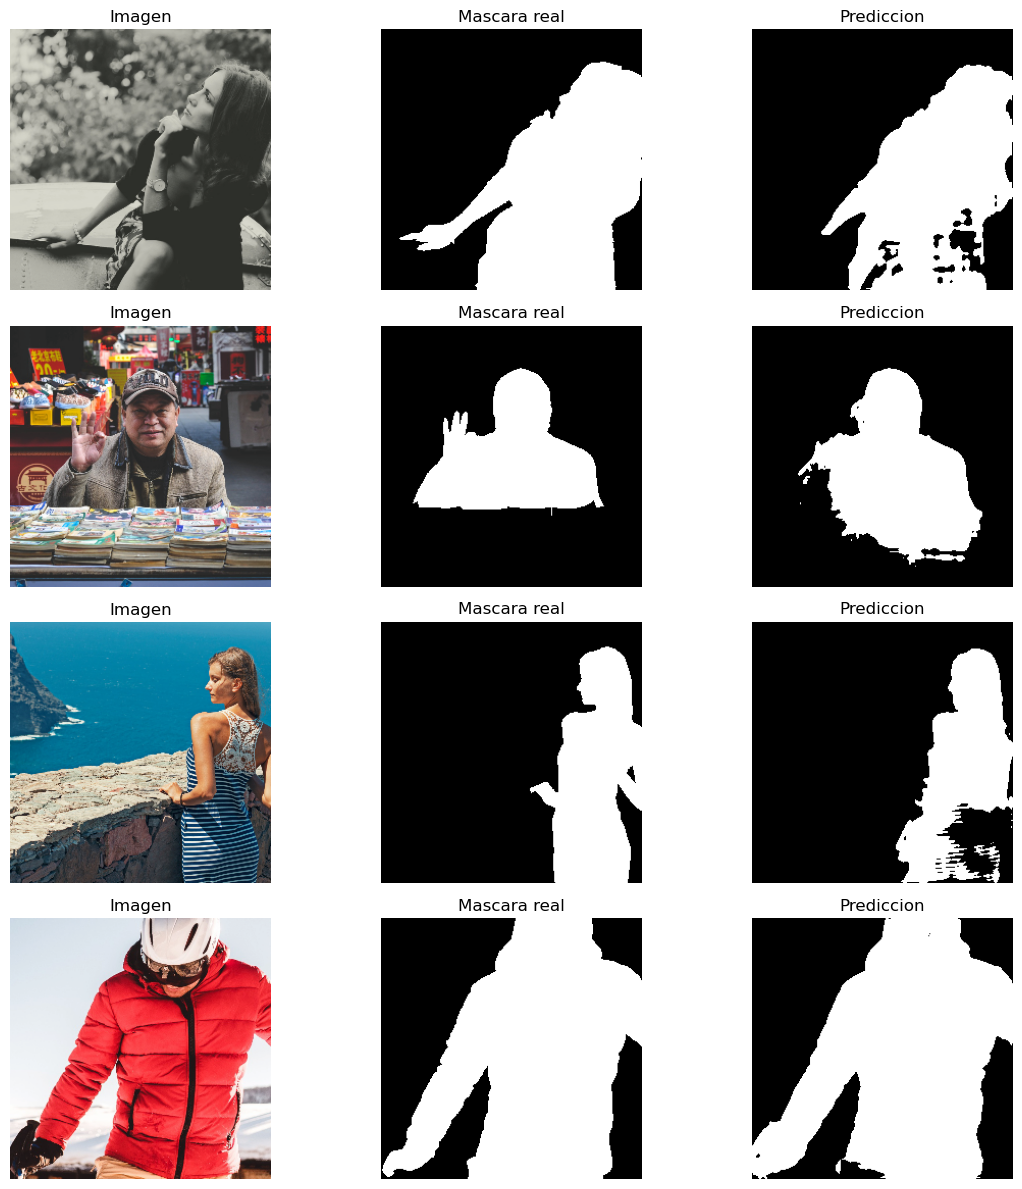

In [30]:
visualizar_predicciones(model, val_loader, device, checkpoint_path="best_unet_6.pth", n_show=4)

## **5. Posibles mejoras y casos borde**

## **6. Submissions a Kaggle**
Pasar mascara a formato rle para subir a la competencia kaggle.
Cargar mejores modelos y reentrenar con todo raw train = train_dev + val para utilizar todos los datos que tenemos disponibles.

### Modelos seleccionados para submission


In [31]:
all_files = np.array(sorted(os.listdir(TRAIN_IMG_DIR)))

full_dataset = SegmentationDataset(
    img_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform_DA,
    filenames=all_files,      
)

full_loader = DataLoader(
    full_dataset,
    batch_size=4,            
    shuffle=True,
    num_workers=0             
)

In [32]:
best_model_path = "best_unet_5.pth"

model = UNet_2(
    n_channels=3,
    n_classes=1,
    base_channels=64,
    bilinear=True,
    activation="relu",
    use_dropout=False,       
    weight_init=None # None para no reiniciar pesos
).to(device)

state_dict = torch.load(best_model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)

C:\Users\Octav\AppData\Local\Temp\ipykernel_17468\677825125.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location=device

UNet_2(
  (inc): DoubleConv_2(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down_2(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv_2(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [33]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_full = train_full(
    model=model,
    loader=full_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=15  
)

torch.save(model.state_dict(), "unet_5_full_train.pth")

  7%|▋         | 1/15 [02:49<39:28, 169.15s/it]

[FULL TRAIN] Epoch 1/15 | Loss: 0.2157 | Dice: 0.8680


 13%|█▎        | 2/15 [05:38<36:42, 169.41s/it]

[FULL TRAIN] Epoch 2/15 | Loss: 0.1980 | Dice: 0.8788


 20%|██        | 3/15 [08:28<33:57, 169.77s/it]

[FULL TRAIN] Epoch 3/15 | Loss: 0.1789 | Dice: 0.8904


 27%|██▋       | 4/15 [11:18<31:04, 169.49s/it]

[FULL TRAIN] Epoch 4/15 | Loss: 0.1831 | Dice: 0.8867


 33%|███▎      | 5/15 [14:07<28:13, 169.37s/it]

[FULL TRAIN] Epoch 5/15 | Loss: 0.1772 | Dice: 0.8906


 40%|████      | 6/15 [16:56<25:24, 169.42s/it]

[FULL TRAIN] Epoch 6/15 | Loss: 0.1706 | Dice: 0.8937


 47%|████▋     | 7/15 [19:46<22:35, 169.48s/it]

[FULL TRAIN] Epoch 7/15 | Loss: 0.1664 | Dice: 0.8978


 53%|█████▎    | 8/15 [22:37<19:50, 170.12s/it]

[FULL TRAIN] Epoch 8/15 | Loss: 0.1552 | Dice: 0.9040


 60%|██████    | 9/15 [25:29<17:03, 170.59s/it]

[FULL TRAIN] Epoch 9/15 | Loss: 0.1635 | Dice: 0.8973


 67%|██████▋   | 10/15 [28:20<14:13, 170.68s/it]

[FULL TRAIN] Epoch 10/15 | Loss: 0.1507 | Dice: 0.9041


 73%|███████▎  | 11/15 [31:11<11:23, 170.82s/it]

[FULL TRAIN] Epoch 11/15 | Loss: 0.1451 | Dice: 0.9092


 80%|████████  | 12/15 [34:12<08:41, 173.90s/it]

[FULL TRAIN] Epoch 12/15 | Loss: 0.1464 | Dice: 0.9076


 87%|████████▋ | 13/15 [37:01<05:45, 172.57s/it]

[FULL TRAIN] Epoch 13/15 | Loss: 0.1353 | Dice: 0.9136


 93%|█████████▎| 14/15 [39:52<02:51, 171.86s/it]

[FULL TRAIN] Epoch 14/15 | Loss: 0.1443 | Dice: 0.9103


100%|██████████| 15/15 [42:41<00:00, 170.77s/it]

[FULL TRAIN] Epoch 15/15 | Loss: 0.1329 | Dice: 0.9168


In [34]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

test_filenames = sorted(os.listdir(TEST_IMG_DIR))

all_ids = []
all_rles = []

for fname in test_filenames:
    img_path = os.path.join(TEST_IMG_DIR, fname)
    
    img_pil = Image.open(img_path).convert("RGB") # Leer imagen original (800x800) en RGB
    img = np.array(img_pil)  # (H_orig, W_orig, 3)
    H_orig, W_orig = img.shape[:2]

    augmented = val_transform(image=img) # Aplicar el mismo transform que usamos para validación
    img_tensor = augmented["image"].unsqueeze(0).to(device) # [1, 3, H, W]

    with torch.no_grad():
        logits = model(img_tensor) # [1, 1, H_resized, W_resized]
        probs  = torch.sigmoid(logits)
        pred   = (probs > 0.5).float().cpu().numpy()[0, 0] # pred esta en la resolucion de la transformacion

    # Necesitamos llevarla a 800x800 para Kaggle
    mask_small = (pred > 0.5).astype("uint8") * 255
    mask_pil = Image.fromarray(mask_small, mode="L")
    mask_resized_pil = mask_pil.resize((W_orig, H_orig), resample=Image.NEAREST) # Redimensiona con NEAREST más prolijo
    mask_resized = np.array(mask_resized_pil)
    mask_bin = (mask_resized > 127).astype("uint8") # Fuerza mascara binaria 0/1

    rle = mask_to_rle(mask_bin)

    image_id = fname 

    all_ids.append(image_id)
    all_rles.append(rle)

submission = pd.DataFrame({
    "id": all_ids,
    "encoded_pixels": all_rles
})

submission.to_csv("submission_3.csv", index=False)
submission.head()

C:\Users\Octav\AppData\Local\Temp\ipykernel_17468\2436563822.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locati

id                                     encoded_pixels
0  1024.png  7960 13 8760 13 9560 13 10360 13 11167 6 11967...
1  1025.png  742 59 1542 59 2342 59 3154 47 3954 47 4754 47...
2  1027.png  175929 16 176729 16 177529 16 178310 47 179110...
3  1037.png  138273 16 139073 16 139873 16 140667 25 140695...
4  1038.png  65382 10 66182 10 66982 10 67760 38 67939 3 67...